In [185]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


# Dataset Description

First we import the data and examine the data at a high level to see what we're working with.

In [186]:
df = pd.read_csv('data/loans_full_schema.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

Immediately we see that we have 10 columns that contain null values
- ``emp_title``
- ``emp_length``
- ``debt_to_income``
- ``annual_income_joint``
- ``verification_income_joint``
- ``debt_to_income_joint``
- ``months_since_last_delinq``
- ``months_since_90d_late``
- ``months_since_last_credit_inquiry``
- ``num_accounts_120d_past_due``

These will be addressed later when we prepare our data for the regression models.

# Visualizations

## Interest Rate Distribution

We'll be attempting to predict the ``interest_rate`` later, so let's first look at a histogram of the distribution.

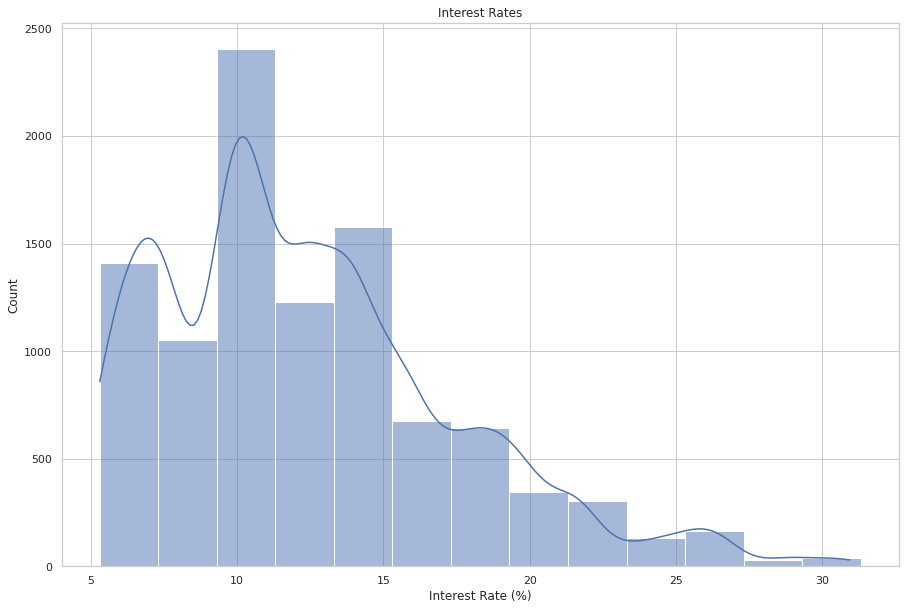

In [187]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='interest_rate', kde=True, binwidth=2)
plt.title('Interest Rates')
plt.xlabel('Interest Rate (%)')
plt.show()

We see the highest concentration of interest rates around 10% with a big dropoff starting around 12%. 

## Interest Rate by Grade

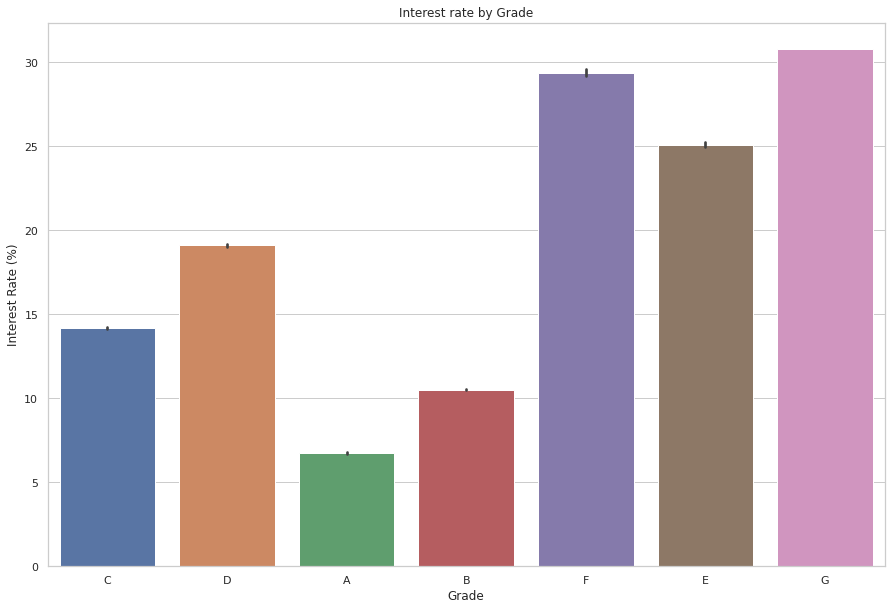

In [188]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=df, x='grade', y='interest_rate')
plt.title('Interest rate by Grade')
plt.xlabel('Grade')
plt.ylabel('Interest Rate (%)')
plt.show()

Hardly surprising, lower grades have higher interest rates.

## Loan Amount Distribution and Status

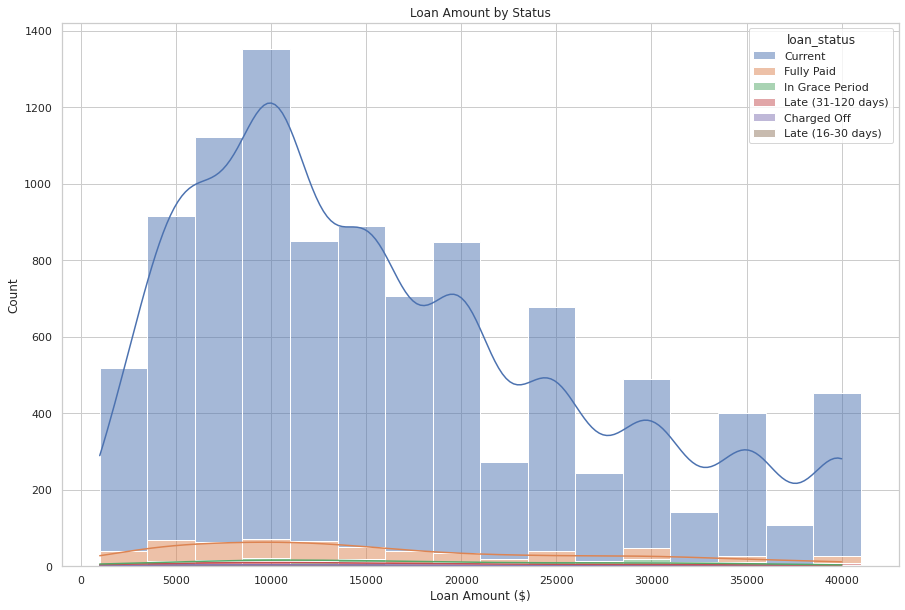

In [189]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='loan_amount', hue='loan_status', multiple='stack', ax=ax, kde=True, binwidth=2500)
plt.title('Loan Amount by Status')
plt.xlabel('Loan Amount ($)')
plt.show()

We see a rapid climb up to the peak at $10,000 then a slow tailing off to the maximum amount of $40,000. We can also see that an overwhelming majority of loans are current.

## Home Ownership and Interest Rates

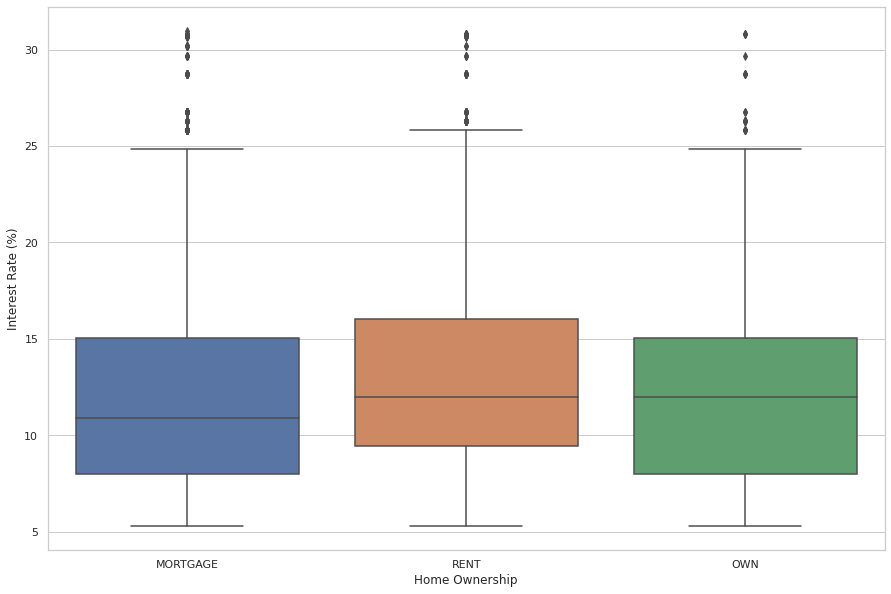

In [190]:
f, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df, x='homeownership', y='interest_rate')
plt.xlabel('Home Ownership')
plt.ylabel('Interest Rate (%)')
plt.show()

It looks like renters have a slightly higher interest rate than home owners, but by a thin margin.

# Annual Income and Loan Status

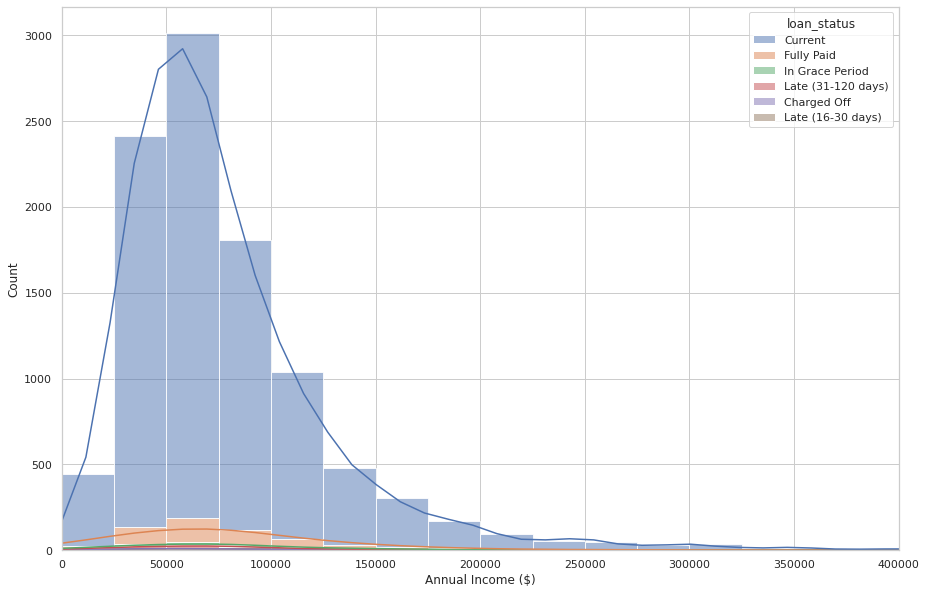

In [191]:
f, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='annual_income', hue='loan_status', multiple='stack', ax=ax, kde=True, binwidth=25000)
plt.xlim(0, 400000)
plt.xlabel('Annual Income ($)')
plt.show()

Our borrower's annual income is concentrated around $50,000. We also see that annual income doesn't seem to effect the loan status very much.

# Predicting Interest Rate

We're going to attempt to predict ``interest_rate`` using two methods: Multiple Linear Regression and Polynomial regression. Before we begin either we first need to prepare our feature set. First we'll split the data into feature set ``X`` and target vector ``y``. Then we create dummy variables to represent our categorical values such as ``homeownership`` and ``application_type`` since regression requires numeric values.

We're making the following assumptions about the data:

1. Variables are normally distributed
2. There is a linear relationship between the independent and dependent variables
3. The variables are measured without error
4. The variables have the same finite variance


In [200]:
X = df.loc[:,df.columns!='interest_rate']
y = df['interest_rate']

# emp_title creates nearly 4000 columns making the dataframe very large so we drop it
X  = X.drop(columns=['emp_title', 'state'], axis=1)
X = pd.get_dummies(X, columns=[
    'homeownership', 
    'verified_income', 
    'verification_income_joint', 
    'loan_purpose', 
    'application_type', 
    'grade', 
    'sub_grade', 
    'issue_month', 
    'loan_status', 
    'initial_listing_status', 
    'disbursement_method'
    ], dummy_na=True)
X.replace(np.nan, 0, inplace=True)

Next we need to split our data into train/test sets.

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Multiple Linear Regression

The first method we'll use to predict ``interest_rate`` will be multiple linear regression.

In [203]:
# build and fit the model
model_mlr = LinearRegression()
model_mlr.fit(X_train, y_train)


# assess the model
fitted = model_mlr.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, fitted))
r2 = r2_score(y_test, fitted)

print('RMSE: ', RMSE)
print('r2: ', r2)

RMSE:  0.07404961363088847
r2:  0.9997931790857887


## Ordinary Least Squared Regression

In [205]:
model_ols = sm.OLS(y_train, X_train)
results = model_ols.fit()

# the OLS module we are using has a nice summary function
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.136e+04
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        19:27:37   Log-Likelihood:                 760.26
No. Observations:                8000   AIC:                            -1325.
Df Residuals:                    7902   BIC:                            -639.8
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## Model refinement

Given more time I would like to narrow down the feature set to the ones that effect the ``interest_rate`` the most. One technique I like to use for such a thing is Backward Elimination in which we run build multiple models dropping the least impactful variable one by one until we end up with a more refined feature set.